In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from tensorflow.python.framework.errors_impl import NotFoundError

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_ch_2_11
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset_r354331.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 500
BATCH_SIZE = 4096
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_r354331.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
with open(DATASET_PATH, 'rb') as file:
    dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=0,
                batch_size=BATCH_SIZE, lr_patience=10, es_patience=60, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_separately_r354331', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Find optimal CFD thresholds (use only the training set)

In [6]:
from src.cfd import find_optimal_cfd_threshold

optimal_cfd_thresholds = {}
for plane, channel in sorted(dataset.keys()):
    print(f'Processing p={plane}, ch={channel}...')
    all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
    X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, X_train, y_train, X_TIME, n_jobs=N_JOBS, plot=False)
    optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold

with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
    pickle.dump(optimal_cfd_thresholds, file)

Processing p=1, ch=2...
Optimal CFD threshold: 0.160
Processing p=1, ch=11...
Optimal CFD threshold: 0.190
Processing p=2, ch=2...
Optimal CFD threshold: 0.215
Processing p=2, ch=11...
Optimal CFD threshold: 0.145
Processing p=3, ch=2...
Optimal CFD threshold: 0.125
Processing p=3, ch=11...
Optimal CFD threshold: 0.180


In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.160
(1, 11): 0.190
(2,  2): 0.215
(2, 11): 0.145
(3,  2): 0.125
(3, 11): 0.180


# Test

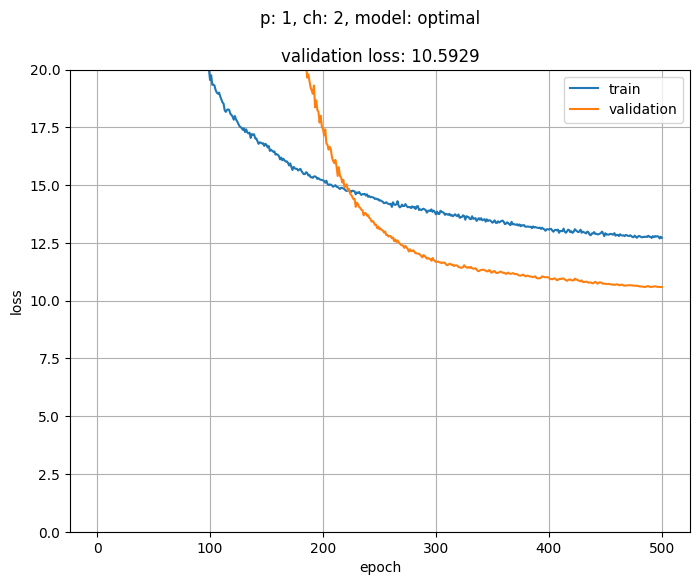

1/1 [==============================] - 0s 373ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


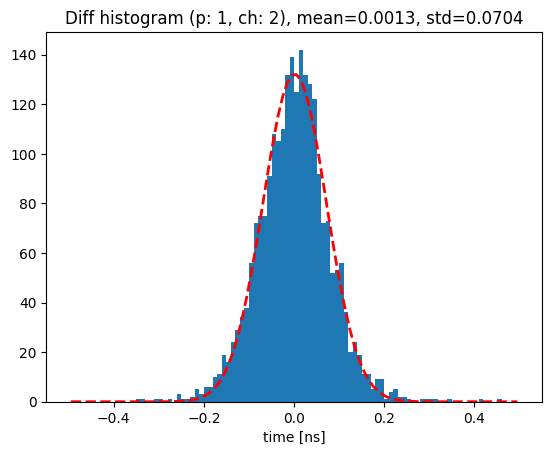

       CFD: 77.39 ps
   optimal: 70.41 ps (improvement: 9.02 %)


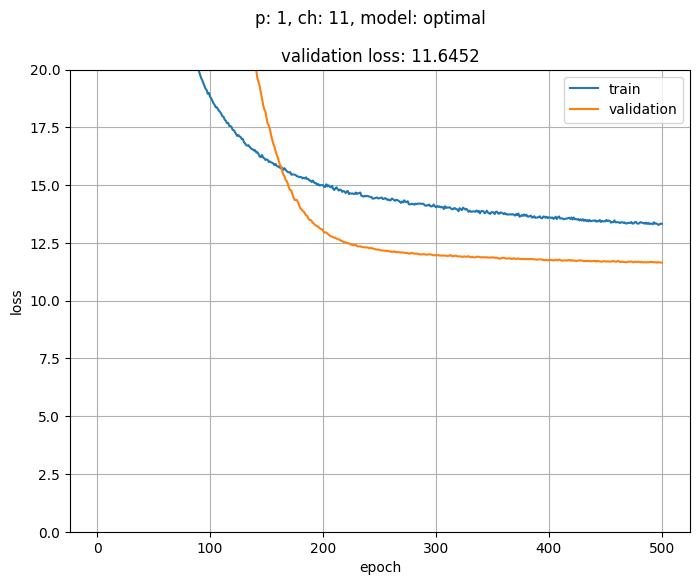

1/1 [==============================] - 0s 430ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


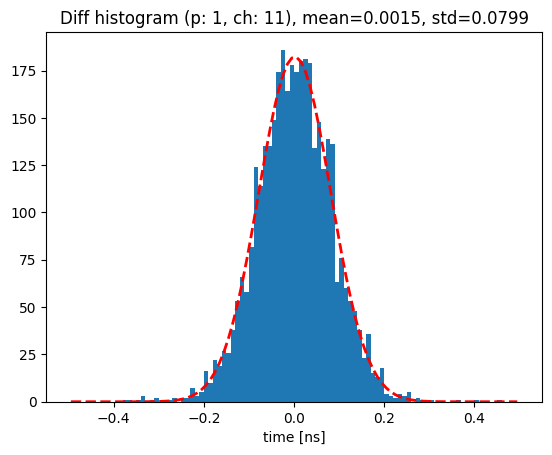

       CFD: 87.91 ps
   optimal: 79.92 ps (improvement: 9.09 %)


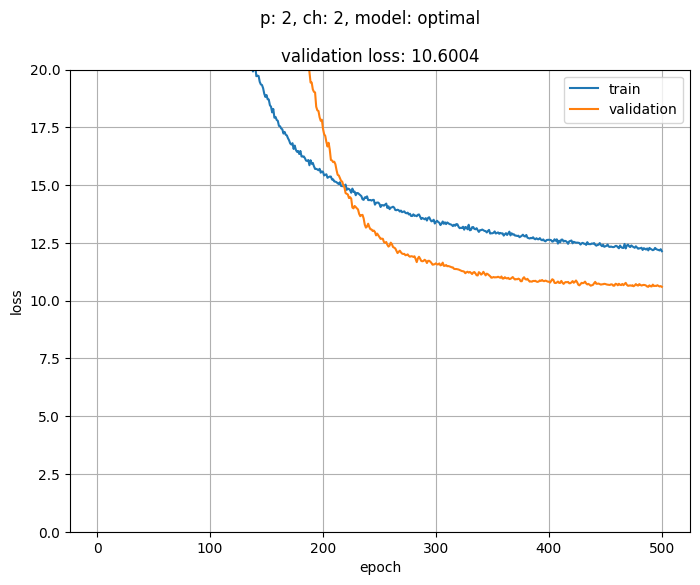

1/1 [==============================] - 0s 332ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


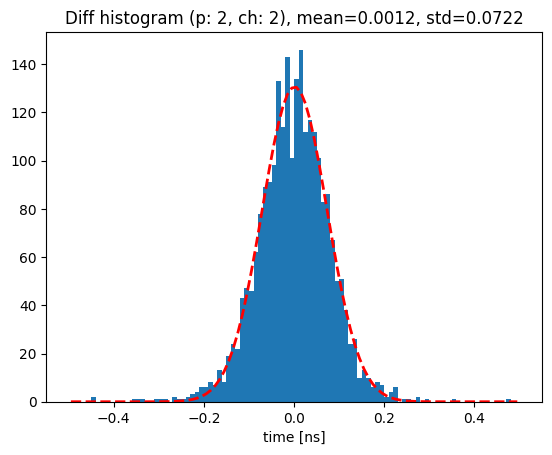

       CFD: 81.60 ps
   optimal: 72.24 ps (improvement: 11.46 %)


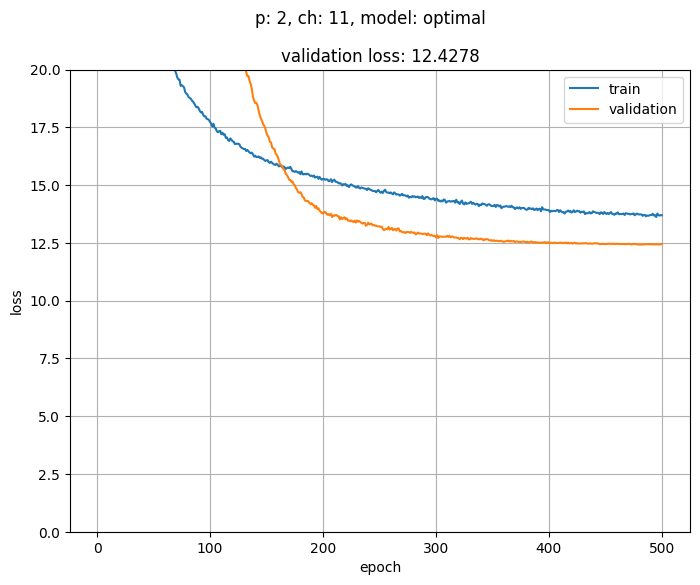

1/1 [==============================] - 0s 394ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


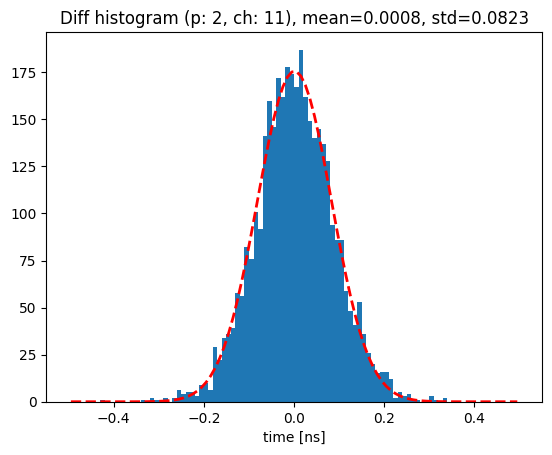

       CFD: 89.56 ps
   optimal: 82.28 ps (improvement: 8.13 %)


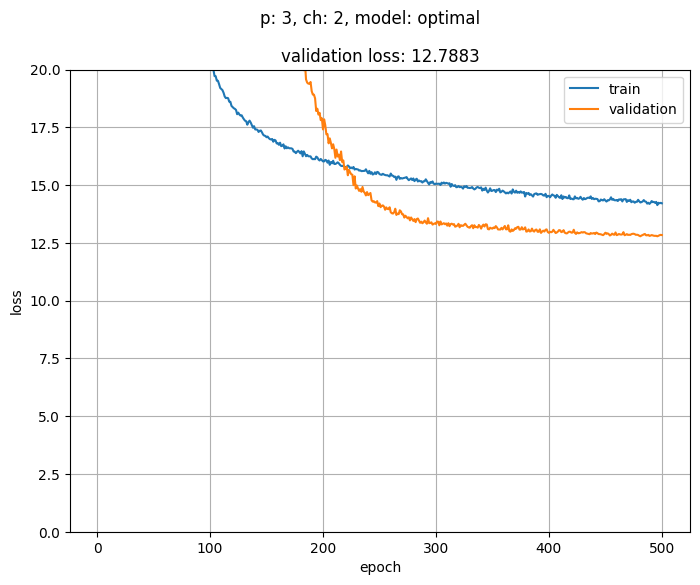

1/1 [==============================] - 0s 318ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


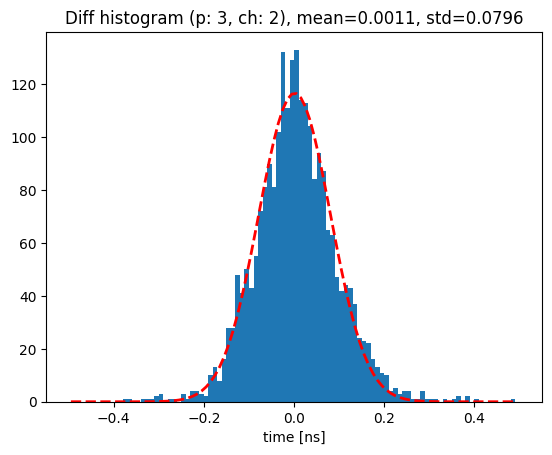

       CFD: 95.25 ps
   optimal: 79.60 ps (improvement: 16.43 %)


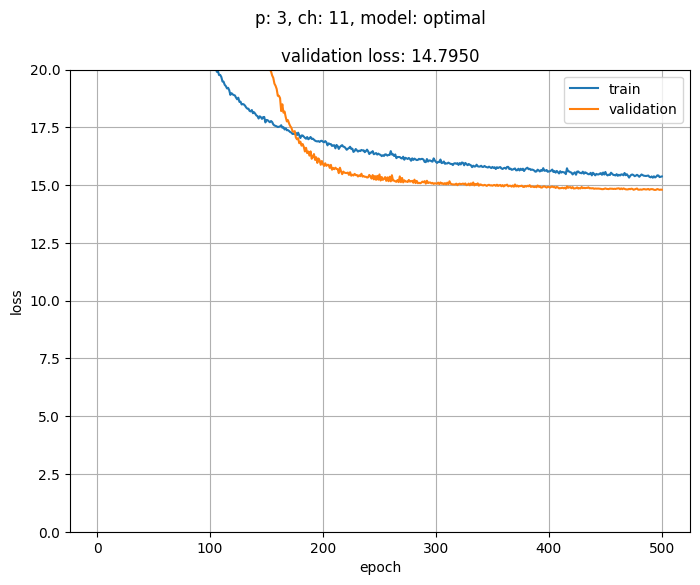

1/1 [==============================] - 0s 394ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


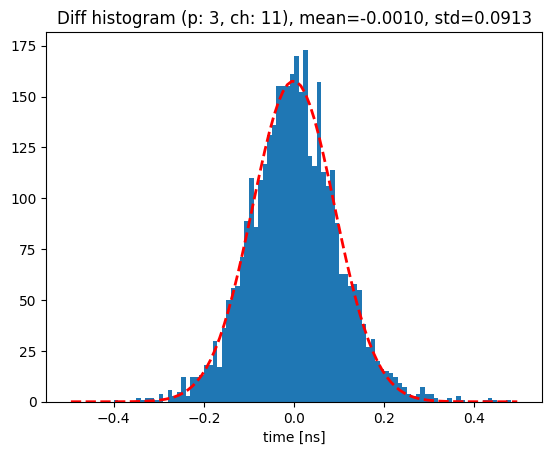

       CFD: 112.76 ps
   optimal: 91.26 ps (improvement: 19.07 %)


In [8]:
improvements = {}
for plane, channel in sorted(dataset.keys()):
    display(HTML(f'<h3>Plane: {plane}, channel: {channel}</h3>'))

    all_X, all_y = dataset[(plane, channel)][0], dataset[(plane, channel)][1]
    X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE,
                                                        random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    # CFD
    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, plane=plane, channel=channel, show=False)

    # Network
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    model = optimal_model_builder_ch_2_11()
    try:
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=False)
    except (FileNotFoundError, NotFoundError, ValueError):
        print(f'Could not find the model for ({plane}, {channel}). Setting train=True')
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train, y_train=Y_heatmap_train,
                              X_val=X_test, y_val=Y_heatmap_test, train=True)

    plot_history(history, f'p: {plane}, ch: {channel}, model: optimal', ymax=20)

    y_pred_model = model_predict(model, X_test)

    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, plane=plane, channel=channel, show=True)

    print('=====================================================================')
    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [9]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  77.39 ps, NN:  70.41 ( 9.02 %)
(1, 11) CFD:  87.91 ps, NN:  79.92 ( 9.09 %)
(2,  2) CFD:  81.60 ps, NN:  72.24 (11.46 %)
(2, 11) CFD:  89.56 ps, NN:  82.28 ( 8.13 %)
(3,  2) CFD:  95.25 ps, NN:  79.60 (16.43 %)
(3, 11) CFD: 112.76 ps, NN:  91.26 (19.07 %)
